# 100kmあたりのガソリン消費量を予測したい

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #3D散布図の描画
%matplotlib inline

In [2]:
car = pd.read_csv("./DATA/measurements.csv",decimal=',') #データCSVの読み込み。decimalでカンマを変換

In [3]:
#データ確認
display(car.head())
car.info()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       388 non-null    float64
 1   consume        388 non-null    float64
 2   speed          388 non-null    int64  
 3   temp_inside    376 non-null    float64
 4   temp_outside   388 non-null    int64  
 5   specials       93 non-null     object 
 6   gas_type       388 non-null    object 
 7   AC             388 non-null    int64  
 8   rain           388 non-null    int64  
 9   sun            388 non-null    int64  
 10  refill liters  13 non-null     float64
 11  refill gas     13 non-null     object 
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


In [4]:
print(car["temp_inside"].isnull().sum())
print(car["refill liters"].isnull().sum())

12
375


In [5]:
car.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


## ＜コメント＞
"specials", "refill liters", "refill gas"は説明変数にならなそう。  
"temp_inside"に欠損値有り　平均値にて埋める  
"gas_type"がobject　→　ダミー変数に置き換えが必要

temp_insideの前処理

In [6]:
car["temp_inside"].value_counts()

21.5    133
22.0    102
22.5     59
20.0     25
23.0     13
21.0     13
25.0     12
24.5      7
20.5      4
24.0      3
25.5      2
23.5      2
19.0      1
Name: temp_inside, dtype: int64

In [7]:
temp_inside_mod = car["temp_inside"].dropna() #NaNを削除
temp_inside_avg = temp_inside_mod.mean() #平均値算出
car["temp_inside"] = car["temp_inside"].fillna(temp_inside_avg)
car["temp_inside"].value_counts() #AVE 21.92...が入っているか？

21.500000    133
22.000000    102
22.500000     59
20.000000     25
23.000000     13
21.000000     13
21.929521     12
25.000000     12
24.500000      7
20.500000      4
24.000000      3
25.500000      2
23.500000      2
19.000000      1
Name: temp_inside, dtype: int64

gas_typeの前処理

In [8]:
car["gas_type"].value_counts()

SP98    228
E10     160
Name: gas_type, dtype: int64

In [9]:
#SP98を0, E10を1に置換
def GasType(x):
    if x == "SP98":
        return 0
    else:
        return 1

car["gas_type_mod"] = car["gas_type"].apply(lambda x: GasType(x))

目的変数と説明変数の関係を可視化

In [10]:
#使う変数だけでdf_carを作成
df_car=car[["distance","consume", "speed", "temp_inside", "temp_outside", "AC", "rain", "sun", "gas_type_mod"]]

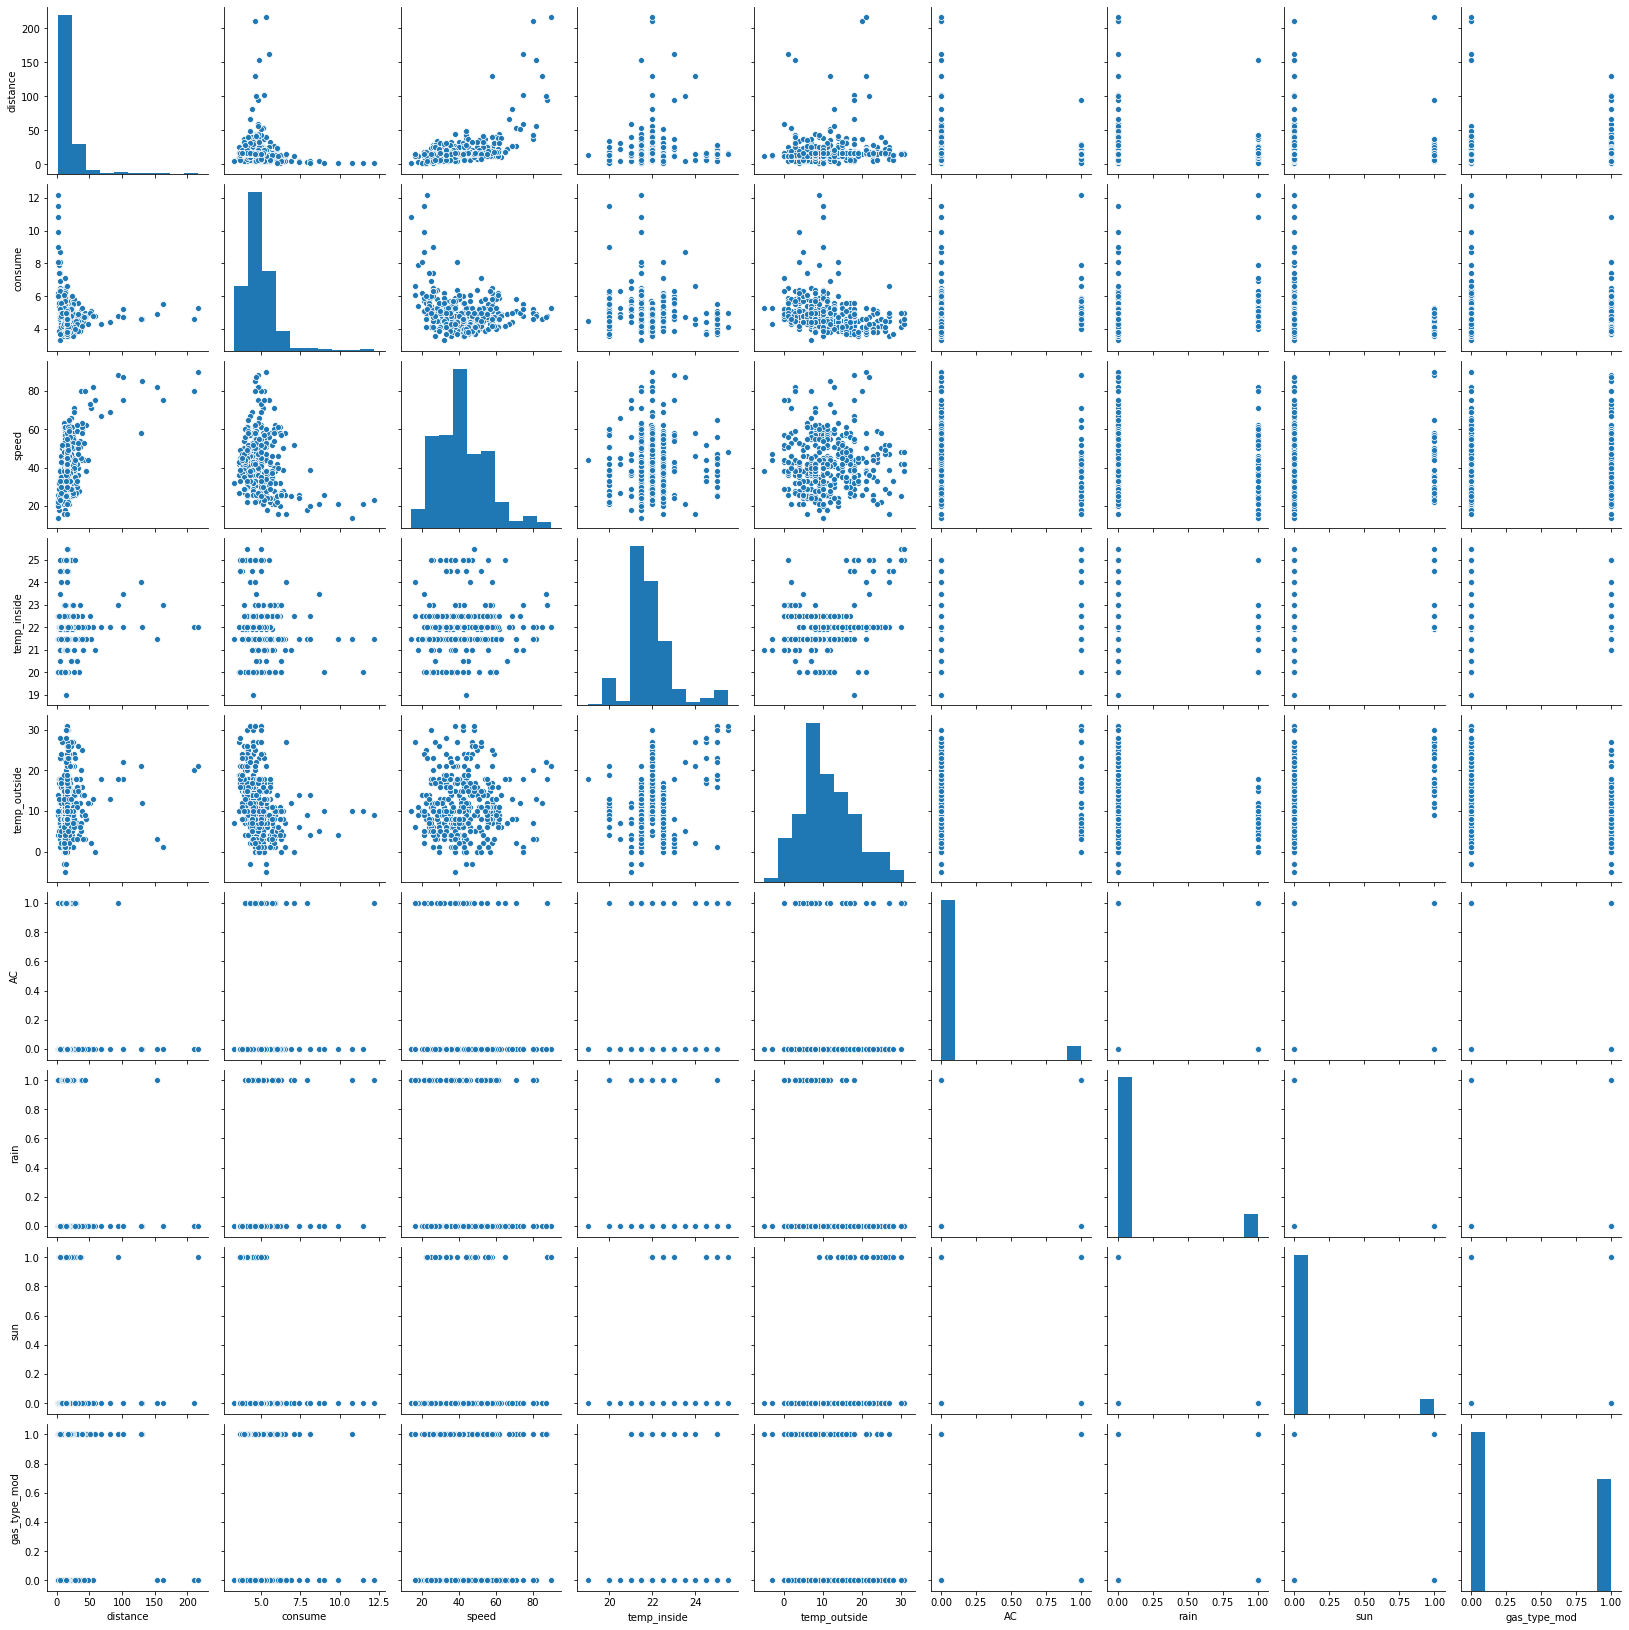

In [11]:
sns.pairplot(df_car)
plt.show()

In [12]:
df_car.corr()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,gas_type_mod
distance,1.000000,-0.128967,0.562299,0.075178,0.088175,-0.025738,-0.019791,0.081120,0.053411
consume,-0.128967,1.000000,-0.227866,-0.160623,-0.320811,0.096591,0.248118,-0.170667,0.015327
speed,0.562299,-0.227866,1.000000,0.059293,0.015411,-0.035408,0.009489,0.081618,0.097360
temp_inside,0.075178,-0.160623,0.059293,1.000000,0.359500,0.297376,-0.036937,0.242248,-0.010198
temp_outside,0.088175,-0.320811,0.015411,0.359500,1.000000,0.167562,-0.186315,0.346903,-0.148705
AC,-0.025738,0.096591,-0.035408,0.297376,0.167562,1.000000,0.242915,0.088598,-0.105285
rain,-0.019791,0.248118,0.009489,-0.036937,-0.186315,0.242915,1.000000,-0.112650,-0.060328
sun,0.081120,-0.170667,0.081618,0.242248,0.346903,0.088598,-0.112650,1.000000,-0.022761
gas_type_mod,0.053411,0.015327,0.097360,-0.010198,-0.148705,-0.105285,-0.060328,-0.022761,1.000000


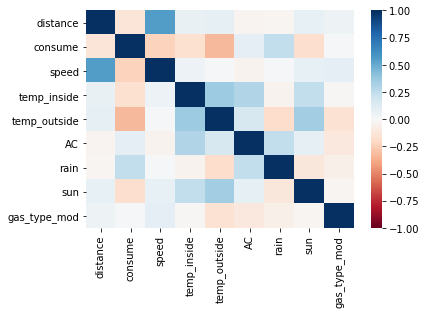

In [13]:
sns.heatmap(df_car.corr(),cmap='RdBu',vmin=-1,vmax=1)
plt.show()

In [18]:
#線形回帰

# 係数を求める
y = df_car["consume"].values
X = df_car[["distance", "speed", "temp_inside", "temp_outside", "AC", "rain", "sun", "gas_type_mod"]].values
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
w4 = regr.coef_[3]
w5 = regr.coef_[4]
w6 = regr.coef_[5]
w7 = regr.coef_[6]
w8 = regr.coef_[7]

print("w0 = {:.3f}".format(w0))
print("w1 = {:.3f}".format(w1))
print("w2 = {:.3f}".format(w2))
print("w3 = {:.3f}".format(w3))
print("w4 = {:.3f}".format(w4))
print("w5 = {:.3f}".format(w5))
print("w6 = {:.3f}".format(w6))
print("w7 = {:.3f}".format(w7))
print("w8 = {:.3f}".format(w8))

w0 = 7.674
w1 = 0.002
w2 = -0.018
w3 = -0.077
w4 = -0.040
w5 = 0.467
w6 = 0.521
w7 = -0.131
w8 = 0.037


In [16]:
# 値を予測
y_pred = regr.predict(X)

# MSEを計算
mse = mean_squared_error(y, y_pred) 
print("MSE = %s"%round(mse,3))

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3))

# MAEを計算
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3))

MSE = 0.845
RMSE = 0.919
MAE = 0.618
